# Co-training

**Autori:** Peter Macinec, Lukas Janik, Vajk Pomichal, Frantisek Sefcik

## Zakladne nastavenia a import kniznic

In [1]:
import pandas as pd
import numpy as np


# plots
import matplotlib.pyplot as plt
import seaborn as sns

import json

import re

import nltk
from nltk.stem.porter import PorterStemmer
import string
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn import model_selection as ms

from sklearn.metrics import confusion_matrix

import statistics

from functools import reduce

import warnings
warnings.filterwarnings('ignore', category=FutureWarning)
warnings.filterwarnings('ignore', category=UserWarning)
pd.options.mode.chained_assignment = None  # default='warn'

### Nacitanie datasetu

Nase data su dostupne v dvoch suboroch, *train.tsv* a *test.tsv*. Nacitame ich oba a vykoname na nich zakladnu analyzu. Zdroj: https://www.kaggle.com/c/stumbleupon

In [2]:
# trenovacie data
df = pd.read_csv('data/train.tsv', sep='\t')

In [3]:
# testovacie data
df_t = pd.read_csv('data/test.tsv', sep='\t')

## Textove atributy

Najskor predspracujeme text. Ziskame ho z atributu boilerplate:

In [4]:
df['body_content'] = df['boilerplate'].apply(lambda x: json.loads(x)['body'])

Teraz odstranime vsetky znaky, ktore nie su znaky slov. Pouzijeme na to regularne vyrazy:

In [5]:
df['body_content'].replace({r'[^\x00-\x7F]+':''}, regex=True, inplace=True)

In [6]:
df['body_content'] = df['body_content'].apply(lambda x: re.sub('[^a-zA-Z]', ' ', str(x)))

Este ako male upravy, aby nas slovnik obsahoval kazde slovo len raz, dame ich vsetky na lowercase a rozdelime texty na slova, aby sme ich nasledne mohli spracovat:

In [7]:
df['body_content'] = df['body_content'].apply(lambda x: str(x).lower().split())

Teraz potrebujeme este odstranit slova, ktore nedavaju vyznam. O jednom raze prevedieme slova na ich korenovy zaklad pouzitim stemmingu:

In [8]:
porter_stemmer = PorterStemmer()
stopwords = set(stopwords.words('english'))

In [9]:
df['body_content'] = df['body_content'].apply(lambda x: [porter_stemmer.stem(word) for word in x if word not in stopwords])

Teraz uz mame vsetky slova pripravene, uz ich len naspat spojime do jednej suvislej vety, aby s nimi vedeli lahsie pracovat algoritmy spracovania textu:

In [10]:
df['body_content_final'] = df['body_content'].apply(lambda x: ' '.join(x))

### TF-IDF

Kedze mame ako atribut text stranky, TF-IDF nam moze pomoct. Vyberieme intuitivne top 1000 slov:

In [11]:
tv = TfidfVectorizer(max_features = 1000)
tf_idf = tv.fit_transform(df['body_content_final']).toarray()

### Atribut URL

Dalsi dobry ukazovatel moze byt URL. Tak isto, natrenujeme na nej TF-IDF s top 1000 slovami. Najskor ich ale musim predspracovat:

In [12]:
df['url_new'] = df['url'].apply(lambda x: re.sub('[^a-zA-Z]', ' ', str(x)))
df['url_new'] = df['url_new'].apply(lambda x: str(x).lower().split())

In [13]:
df['url_new'] = df['url_new'].apply(lambda x: [porter_stemmer.stem(word) for word in x if word not in stopwords])

In [14]:
df['url_final'] = df['url_new'].apply(lambda x: ' '.join(x))

In [15]:
tv_url = TfidfVectorizer(max_features = 1000)
tf_idf_url = tv_url.fit_transform(df['url_final']).toarray()

## Numericke atributy

Ako posledne atributy vyberieme vsetky numericke, ktore by nam mohli nieco prezradit. Pouzijeme ich spolu s TF-IDF crtami z URL.

In [16]:
num_feature_set = ['avglinksize', 'commonlinkratio_1', 'commonlinkratio_2', 'commonlinkratio_3', 'commonlinkratio_4',
                   'hasDomainLink','lengthyLinkDomain','linkwordscore','numberOfLinks',
                   'numwords_in_url', 'parametrizedLinkRatio']

## Benchmark model

Natrenujeme benchmarkovy model, ktory bude natrenovany na vsetkych atributoch. Jeho vysledky sa nasledne budeme snazit dosiahnut s minimom oznacenych dat s co-trainingom.

In [17]:
y = df.label

Postupne vyberieme vsetky crty, ktore sme popisali vyssie. Aj TF-IDF z textov, aj z URL, aj numericke atributy:

In [18]:
df1 = df.loc[:, num_feature_set]

In [19]:
df2 = pd.DataFrame(tf_idf_url)

In [20]:
X_temp = pd.concat([df2, pd.DataFrame(tf_idf)], axis=1, join_axes=[df2.index])
X_temp.columns = list(range(0,2000))

In [21]:
X = pd.concat([df1, X_temp], axis=1, join_axes=[df1.index])

Data uz mame spojene, podme sa na ne pozriet:

In [22]:
X.head()

,avglinksize,commonlinkratio_1,commonlinkratio_2,commonlinkratio_3,commonlinkratio_4,hasDomainLink,lengthyLinkDomain,linkwordscore,numberOfLinks,numwords_in_url,...,1990,1991,1992,1993,1994,1995,1996,1997,1998,1999
0,2.055556,0.676471,0.205882,0.047059,0.023529,0,1,24,170,8,...,0.0,0.00000,0.157927,0.0,0.000000,0.028198,0.0,0.0,0.064583,0.0
1,3.677966,0.508021,0.288770,0.213904,0.144385,0,1,40,187,9,...,0.0,0.00000,0.031715,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0
2,2.382883,0.562016,0.321705,0.120155,0.042636,0,1,55,258,11,...,0.0,0.00000,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0
3,1.543103,0.400000,0.100000,0.016667,0.000000,0,0,24,120,5,...,0.0,0.00000,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0
4,2.676471,0.500000,0.222222,0.123457,0.043210,0,1,14,162,10,...,0.0,0.02762,0.107720,0.0,0.129191,0.128223,0.0,0.0,0.088102,0.0


Vsetko vyzera byt v poriadku a pripravene. Este je potrebne pomenovat stlpce unikatnymi nazvami, co vyzaduju niektore algoritmy:

In [23]:
col_names1 = list(range(0,1000))
col_names1 = num_feature_set + col_names1
col_names2 = list(range(1000,2000))

Rozdelime data na trenovaciu a testovaciu mnozinu v pomere 80% a 20%:

In [24]:
X_train, X_test, y_train, y_test = ms.train_test_split(X, y, test_size=0.2, random_state=42)

Ako benchmarkovy model sme vybrali RandomForest. Vyskusali sme aj dalsie klasifikatory, ale RandomForest sa ukazal ako najlepsi z nich. Parametre boli zvolene najskor intuitivne, potom vyladene.

In [25]:
benchmark_clf = RandomForestClassifier(n_estimators=500, max_depth=20,
                              random_state=10)

In [26]:
benchmark_clf.fit(X_train, y_train)
y_pred = benchmark_clf.predict(X_test)

Podme sa pozriet na vysledky predikcie:

In [27]:
confusion_matrix(y_test, y_pred)

array([[656,  74],
       [221, 528]], dtype=int64)

In [28]:
accuracy_score(y_test, y_pred)

0.8005409060175794

Accuracy 80% nie je zly vysledok. Teraz vieme, aky je strop a k comu sa chceme priblizit s co-trainingom a malym poctom oznacenych dat.

## Co-training zhodnotenie

Benchmark model uz mame natrenovany, tak este vyskusame co-training. Pouzijeme obe varianty, aj s iteraciami aj s thresholdom.

In [29]:
class CombinedClassifier:
    
    def __init__(self,clf1, clf2, cols1, cols2):
        self.clf1 = clf1
        self.clf2 = clf2
        self.cols1 = cols1
        self.cols2 = cols2
        
    def predict(self, df):
        result = []
        predict1 = self.clf1.predict_proba(df[self.cols1])
        predict2 = self.clf2.predict_proba(df[self.cols2])
        
        for i in range(len(df)):
            prob0 = predict1[i][0] * predict2[i][0]
            prob1 = predict1[i][1] * predict2[i][1]
            res = 0 if prob0 > prob1 else 1
            result.append(res)
        return result

### Co-training s iteraciami

Ako prvy vyskusame co-training s iteraciami, ktory pouzili uz povodni autori (s drobnymi zmenami).

In [30]:
def co_training(L, U, col_names1, col_names2, clf1, clf2,u=75, k=30,p=1,n=3, label='label', X_test=None, y_test=None, random_state=None):
    '''
    L - labeled data
    U - unlabeled data
    col_names1 - columns for clf1
    col_names2 - columns for clf2
    clf1 - classificator1
    clf2 - classificator2
    u - number of unlabeled data for training
    k - number of iteration
    p - number of positive examles to add label per iteration
    n - number of negative examles to add label per iteration
    label - name of column in L whit label
    '''
    
    k0 = k
    pred_1 = []
    pred_2 = []
    while k > 0:
        # step 1: Use L to train a classifier h1 that considers only the x1 portion of x
        clf1 = clf1.fit(L[col_names1],  L[label])
        
        # step 2: Use L, to train a classifier h2 that considers only the x2 portion of x
        clf2 = clf2.fit(L[col_names2], L[label])
        
        # step 3: Allow hl to label p positive and n negative examples from U
        predicted_prob1 = clf1.predict_proba(U[col_names1])
        top_positive1 = predicted_prob1[:,1].argsort()[-p:]
        top_negative1 = predicted_prob1[:,0].argsort()[-n:]
        
        # step 4: Allow hl to label p positive and n negative examples from U
        predicted_prob2 = clf2.predict_proba(U[col_names2])
        top_positive2 = predicted_prob2[:,1].argsort()[-p:]
        top_negative2 = predicted_prob2[:,0].argsort()[-n:]    
        
        # step 5: Add these self-labeled examples to L
        positive_ind = U.iloc[np.unique(np.concatenate((top_positive1,top_positive2))),:].index
        negative_ind = U.iloc[np.unique(np.concatenate((top_negative1,top_negative2))),:].index
        self_labeled = U.loc[np.unique(np.concatenate((positive_ind,negative_ind))),:]
        U.drop(self_labeled.index, inplace=True)
        self_labeled.loc[positive_ind, label] = 1
        self_labeled.loc[negative_ind, label] = 0
        L = pd.concat([L, self_labeled])
    
        if (X_test is not None and y_test is not None):
            pred = clf1.predict(X_test[col_names1])
            pred_1.append(accuracy_score(y_test,pred))
            
            pred = clf2.predict(X_test[col_names2])
            pred_2.append(accuracy_score(y_test,pred))

        k -= 1
    
    return [clf1, clf2, pred_1, pred_2]

rozdelime stlpce pre dva klasifikatory

In [31]:
col_names1 = list(range(0,1000))
col_names1 = num_feature_set + col_names1
col_names2 = list(range(1000,2000))

Ako dva vstupne klasifikatory pouzijeme logisticke regresie. Dosahovali podobne vysledky ako ine klasifikatory, avsak su velmi efektivne. Pre otestovanie viacerych behov je to idealna volba.

Pouzijeme na vstupe 20 (10 positive, 10 negative) olabovanych zaznamov:

In [32]:
scores = [[0 for _ in range(3)] for _ in range(30)]

for x in range(30):
    df_x0 = X_train[y_train == 0].sample(10)
    df_x1 = X_train[y_train == 1].sample(10)
    
    train = pd.concat([df_x0,df_x1])
    x_train = X_train.drop(train.index)
    train['label'] = y_train.loc[train.index]

    clf1 = LogisticRegression(n_jobs=-1)
    clf2 = LogisticRegression(n_jobs=-1)

    new_1, new_2, scores[x][0], scores[x][1] = co_training(L=train,U=x_train, 
                               col_names1=col_names1,
                               col_names2=col_names2, clf1=clf1, clf2=clf2, k=30, 
                                                           n=2, p=2, X_test=X_test, y_test=y_test)
    
    
    print("iteration:", x)

    cl = CombinedClassifier(new_1,new_2,col_names1,col_names2)
    pred = cl.predict(X_test)
    scores[x][2] = accuracy_score(y_test, pred)

iteration: 0
iteration: 1
iteration: 2
iteration: 3
iteration: 4
iteration: 5
iteration: 6
iteration: 7
iteration: 8
iteration: 9
iteration: 10
iteration: 11
iteration: 12
iteration: 13
iteration: 14
iteration: 15
iteration: 16
iteration: 17
iteration: 18
iteration: 19
iteration: 20
iteration: 21
iteration: 22
iteration: 23
iteration: 24
iteration: 25
iteration: 26
iteration: 27
iteration: 28
iteration: 29


Nasledne zistime ako sa darilo klasifikatorom v uceni pocas co-trainingu:

In [33]:
avg_accuracy1 = []
avg_accuracy2 = []
model_accuracy1 = []
model_accuracy2 = []
for i in range(30):
    sum_1 = 0 
    sum_2 = 0
    for j in range(30):
        sum_1 += scores[j][0][i]
        sum_2 += scores[j][1][i]
        if i == 29:
            model_accuracy1.append(scores[j][0][i])
            model_accuracy2.append(scores[j][1][i])
    avg_accuracy1.append(sum_1 / 30)
    avg_accuracy2.append(sum_2 / 30)

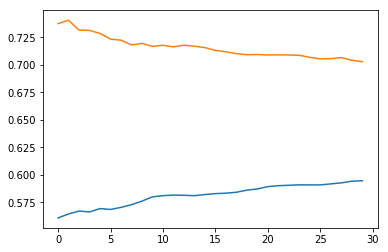

In [34]:
plt.plot(avg_accuracy1)
plt.plot(avg_accuracy2)

Jednotlive spustenia sa od seba znacne odlisuju, avsak stale mozeme vidiet trend a sice, lepsi klasifikator pomoze tomu horsiemu dosiahnut zlepsenie, avsak sam seba o nieco zhorsi. 

Pozrieme sa aka je accuracy 1. klasifikatora po 30 behoch:

In [35]:
print("Min: " + str(np.min(model_accuracy1)))
print("Max: " + str(np.max(model_accuracy1)))
print("Avg: " + str(np.mean(model_accuracy1)))
print("Std: " + str(np.std(model_accuracy1)))

Min: 0.4665314401622718
Max: 0.6308316430020284
Avg: 0.5946810908271355
Std: 0.03790474472101761


Pozrieme sa aka je accuracy 2. klasifikatora po 30 behoch:

In [36]:
print("Min: " + str(np.min(model_accuracy2)))
print("Max: " + str(np.max(model_accuracy2)))
print("Avg: " + str(np.mean(model_accuracy2)))
print("Std: " + str(np.std(model_accuracy2)))

Min: 0.6274509803921569
Max: 0.7748478701825557
Avg: 0.702839756592292
Std: 0.034876359128010584


Pozrieme sa na accuracy kombinovaneho klasifikatora:

In [37]:
score_combined = []

for i in range(30):
    score_combined.append(scores[i][2])

print("Min: " + str(np.min(score_combined)))
print("Max: " + str(np.max(score_combined)))
print("Avg: " + str(np.mean(score_combined)))
print("Std: " + str(np.std(score_combined)))

Min: 0.5409060175794456
Max: 0.6997971602434077
Avg: 0.6435429344151454
Std: 0.036474576622485315


V priemere sa uspesnost pohybuje okolo 65%, ale vidime, ze su pomerne velke vykyvy medzi min a max. Pravdepodobne je to sposobena zavislostou na kvalite vstupnych dat, ktore su oznacene

#### Vacsia vstupna mnozina oznacenych dat a vyssi pocet iteracii

Skusme drobnu zmenu parametrov: 
- zvysime pocet vzoriek, ktore budeme vyberat pre pozitivnu a negativnu triedu (mohlo by to priniest stabilnejsie vysledky)
- zvysime pocet iteracii

In [38]:
X_train.shape

(5916, 2011)

In [39]:
scores = [[0 for _ in range(3)] for _ in range(30)]

for x in range(30):
    df_x0 = X_train[y_train == 0].sample(30)
    df_x1 = X_train[y_train == 1].sample(30)
    
    train = pd.concat([df_x0,df_x1])
    x_train = X_train.drop(train.index)
    train['label'] = y_train.loc[train.index]

    clf1 = LogisticRegression(n_jobs=-1)
    clf2 = LogisticRegression(n_jobs=-1)

    new_1, new_2, scores[x][0], scores[x][1] = co_training(L=train,U=x_train, 
                               col_names1=col_names1,
                               col_names2=col_names2, clf1=clf1, clf2=clf2, k=60, 
                                                           n=2, p=2, X_test=X_test, y_test=y_test)
    
    
    print("iteration: ",x)

    cl = CombinedClassifier(new_1,new_2,col_names1,col_names2)
    pred = cl.predict(X_test)
    scores[x][2] = accuracy_score(y_test, pred)

iteration:  0
iteration:  1
iteration:  2
iteration:  3
iteration:  4
iteration:  5
iteration:  6
iteration:  7
iteration:  8
iteration:  9
iteration:  10
iteration:  11
iteration:  12
iteration:  13
iteration:  14
iteration:  15
iteration:  16
iteration:  17
iteration:  18
iteration:  19
iteration:  20
iteration:  21
iteration:  22
iteration:  23
iteration:  24
iteration:  25
iteration:  26
iteration:  27
iteration:  28
iteration:  29


In [40]:
avg_accuracy1 = []
avg_accuracy2 = []
model_accuracy1 = []
model_accuracy2 = []
for i in range(60):
    sum_1 = 0 
    sum_2 = 0
    for j in range(30):
        sum_1 += scores[j][0][i]
        sum_2 += scores[j][1][i]
        if i == 29:
            model_accuracy1.append(scores[j][0][i])
            model_accuracy2.append(scores[j][1][i])
    avg_accuracy1.append(sum_1 / 30)
    avg_accuracy2.append(sum_2 / 30)

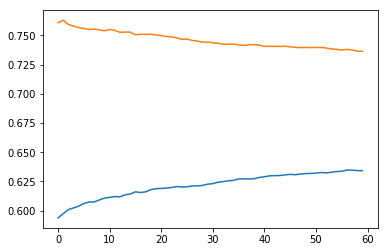

In [41]:
plt.plot(avg_accuracy1)
plt.plot(avg_accuracy2)

Rovnako ako v predoslom pripade sa opat pozrieme na priebeh co-trainingu pomocou grafu a statisticky. Opat mozeme na grafe vidiet rovnaky trend.

In [42]:
print("Min: " + str(np.min(model_accuracy1)))
print("Max: " + str(np.max(model_accuracy1)))
print("Avg: " + str(np.mean(model_accuracy1)))
print("Std: " + str(np.std(model_accuracy1)))

Min: 0.5855307640297498
Max: 0.6484110885733604
Avg: 0.6226729772368716
Std: 0.015315989465076459


In [43]:
print("Min: " + str(np.min(model_accuracy2)))
print("Max: " + str(np.max(model_accuracy2)))
print("Avg: " + str(np.mean(model_accuracy2)))
print("Std: " + str(np.std(model_accuracy2)))

Min: 0.6964164976335362
Max: 0.7789046653144016
Avg: 0.74412891593419
Std: 0.022990284392959685


In [44]:
score_combined = []

for i in range(30):
    score_combined.append(scores[i][2])

print("Min: " + str(np.min(score_combined)))
print("Max: " + str(np.max(score_combined)))
print("Avg: " + str(np.mean(score_combined)))
print("Std: " + str(np.std(score_combined)))

Min: 0.6619337390128465
Max: 0.7450980392156863
Avg: 0.6961460446247464
Std: 0.02084243616165622


Co sa tyka skore, v priemere vidime mierne zlepsenia (do 5%, ale zlepsili sa vsetky klasifikatory). Taktiez sa znizil rozdiel medzi min a max.

### Co-training s prahovou hodnotou (threshold)

Ako sme videli, co-training s iteraciami dosiahol dobre vysledky, ale na ukor jedneho klasifikatora sa zhorsoval druhy. Skusime variantu s thresholdom: Algoritmus bezi, kym ma dostatok dat pripadne vie urcit dostatok nov7ch labelov s urcitou nastavenou istotou

In [45]:
def co_training_threshold(L, U, col_names1, col_names2, clf1, clf2, 
                          label='label', random_state=None, X_test=None, y_test=None, threshold=0.8, 
                         n=5, p=5):
    '''
    L - labeled data
    U - unlabeled data
    col_names1 - columns for clf1
    col_names2 - columns for clf2
    clf1 - classificator1
    clf2 - classificator2
    label - name of column in L whit label
    threshold - threshold of predictions probability
    '''
    
    pred_1 = []
    pred_2 = []
    while len(U) > n + p:
        # step 1: Use L to train a classifier h1 that considers only the x1 portion of x
        clf1 = clf1.fit(L[col_names1],  L[label])
        
        # step 2: Use L, to train a classifier h2 that considers only the x2 portion of x
        clf2 = clf2.fit(L[col_names2], L[label])
        
        # step 3: Allow hl to label p positive and n negative examples from U
        predicted_prob1 = clf1.predict_proba(U[col_names1])
        top_positive1 = [x for x in predicted_prob1[:,1].argsort()[-p:] if predicted_prob1[x,1] > threshold] 
        top_negative1 = [x for x in predicted_prob1[:,0].argsort()[-p:] if predicted_prob1[x,0] > threshold]
        
        
        
        # step 4: Allow hl to label p positive and n negative examples from U
        predicted_prob2 = clf2.predict_proba(U[col_names2]) 
        top_positive2 = [x for x in predicted_prob2[:,1].argsort()[-p:] if predicted_prob2[x,1] > threshold]
        top_negative2 = [x for x in predicted_prob2[:,0].argsort()[-n:] if predicted_prob2[x,0] > threshold]
        
        # step 5: Add these self-labeled examples to L, if less n + p labels are added, break 
        if(np.unique(np.concatenate((top_positive1,top_positive2, top_negative1, top_negative2))).size < n + p):
            if (X_test is not None and y_test is not None):
                pred = clf1.predict(X_test[col_names1])
                pred_1.append(accuracy_score(y_test,pred))

                pred = clf2.predict(X_test[col_names2])
                pred_2.append(accuracy_score(y_test,pred))
                
            return [clf1,clf2, pred_1, pred_2]
        
        
        positive_ind = U.iloc[np.unique(np.concatenate((top_positive1,top_positive2))),:].index
        negative_ind = U.iloc[np.unique(np.concatenate((top_negative1,top_negative2))),:].index
        self_labeled = U.loc[np.unique(np.concatenate((positive_ind,negative_ind))),:]
        U.drop(self_labeled.index, inplace=True)
        self_labeled.loc[positive_ind, label] = 1
        self_labeled.loc[negative_ind, label] = 0
        L = pd.concat([L, self_labeled])
        
        if (X_test is not None and y_test is not None):
            pred = clf1.predict(X_test[col_names1])
            pred_1.append(accuracy_score(y_test,pred))
            
            pred = clf2.predict(X_test[col_names2])
            pred_2.append(accuracy_score(y_test,pred))
    
    return [clf1, clf2, pred_1, pred_2]

Opat vyberieme na vstupe 20 zaznamov. Threshold dame velmi prisny, 90% istoty pre vyber prvku:

In [46]:
scores_threshold = [[0 for _ in range(3)] for _ in range(30)]

for x in range(30):
    df_x0 = X_train[y_train == 0].sample(10)
    df_x1 = X_train[y_train == 1].sample(10)
    
    train = pd.concat([df_x0,df_x1])
    x_train = X_train.drop(train.index)
    train['label'] = y_train.loc[train.index]

    clf1 = LogisticRegression(n_jobs=-1)
    clf2 = LogisticRegression(n_jobs=-1)

    new_1, new_2, scores_threshold[x][0], scores_threshold[x][1] = co_training_threshold(L=train.copy(),U=x_train.copy(), 
                               col_names1=col_names1,
                               col_names2=col_names2, clf1=clf1, clf2=clf2, 
                                                                     X_test=X_test, y_test=y_test, 
                                                                     n=5,p=5,threshold=0.90)
    print("iteration: ",x)
    
    cl = CombinedClassifier(new_1,new_2,col_names1,col_names2)
    pred = cl.predict(X_test)
    scores_threshold[x][2] = accuracy_score(y_test, pred)

iteration:  0
iteration:  1
iteration:  2
iteration:  3
iteration:  4
iteration:  5
iteration:  6
iteration:  7
iteration:  8
iteration:  9
iteration:  10
iteration:  11
iteration:  12
iteration:  13
iteration:  14
iteration:  15
iteration:  16
iteration:  17
iteration:  18
iteration:  19
iteration:  20
iteration:  21
iteration:  22
iteration:  23
iteration:  24
iteration:  25
iteration:  26
iteration:  27
iteration:  28
iteration:  29


In [47]:
model_accuracy1 = []
model_accuracy2 = []
for j in range(30):
    model_accuracy1.append(scores_threshold[j][0][-1])
    model_accuracy2.append(scores_threshold[j][1][-1])    

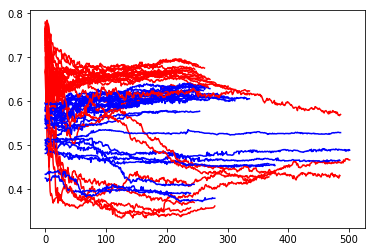

In [48]:
for j in range(30):
    plt.plot(scores_threshold[j][0],'b')
    plt.plot(scores_threshold[j][1], 'r')

V grafe sme vykreslili priebehy hodnoty accuracy vsetkych modelov (dokopy 60), vidime podobny trend, ako v pripade predtym, lepi klasifikator sa zhorsi, kym ten horsi sa mierne zlepsuje

Pre lepsie znazornenie sa pozrieme este na jeden konretny priklad dvojice modelov

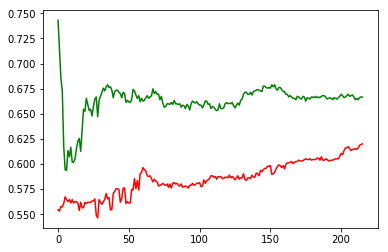

In [49]:
plt.plot(scores_threshold[20][0],'r')
plt.plot(scores_threshold[20][1],'g')

Pozrime sa na statistiky skore, aby sme ho mohli porovnat s co-trainingom s iteraciami:

In [50]:
print("Min: " + str(np.min(model_accuracy1)))
print("Max: " + str(np.max(model_accuracy1)))
print("Avg: " + str(np.mean(model_accuracy1)))
print("Std: " + str(np.std(model_accuracy1)))

Min: 0.3793103448275862
Max: 0.6355645706558486
Avg: 0.5580121703853956
Std: 0.07916010456358391


In [51]:
print("Min: " + str(np.min(model_accuracy2)))
print("Max: " + str(np.max(model_accuracy2)))
print("Avg: " + str(np.mean(model_accuracy2)))
print("Std: " + str(np.std(model_accuracy2)))

Min: 0.35767410412440837
Max: 0.7552400270453009
Avg: 0.6045300878972278
Std: 0.11679353172503369


In [52]:
score_combined = []

for i in range(30):
    score_combined.append(scores_threshold[i][2])

print("Min: " + str(np.min(score_combined)))
print("Max: " + str(np.max(score_combined)))
print("Avg: " + str(np.mean(score_combined)))
print("Std: " + str(np.std(score_combined)))

Min: 0.37322515212981744
Max: 0.651791751183232
Avg: 0.5719630380887987
Std: 0.0880584733668945


Ako vidime, skore je celkom porovnatelne s co-trainingom s iteraciami, avsak dosahuje mierne horsie vysledky. Zda sa, ze je teda lepsie pouzit ten s iteraciami. Skusme vsak este pridat viacero olabovanych dat.

#### Vacsi pocet vstupnych oznacenych dat

Skusme opat zmenu parametrov - zvysenie poctu vybranych vzoriek pozitivnej a negativnej triedy:

In [53]:
scores_threshold = [[0 for _ in range(3)] for _ in range(30)]

for x in range(30):
    df_x0 = X_train[y_train == 0].sample(30)
    df_x1 = X_train[y_train == 1].sample(30)
    
    train = pd.concat([df_x0,df_x1])
    x_train = X_train.drop(train.index)
    train['label'] = y_train.loc[train.index]

    clf1 = LogisticRegression(n_jobs=-1)
    clf2 = LogisticRegression(n_jobs=-1)

    new_1, new_2, scores_threshold[x][0], scores_threshold[x][1] = co_training_threshold(L=train.copy(),U=x_train.copy(), 
                               col_names1=col_names1,
                               col_names2=col_names2, clf1=clf1, clf2=clf2, 
                                                                     X_test=X_test, y_test=y_test, 
                                                                     n=5,p=5,threshold=0.90)
    print("iteration:",x)
    

    cl = CombinedClassifier(new_1,new_2,col_names1,col_names2)
    pred = cl.predict(X_test)
    scores_threshold[x][2] = accuracy_score(y_test, pred)

iteration: 0
iteration: 1
iteration: 2
iteration: 3
iteration: 4
iteration: 5
iteration: 6
iteration: 7
iteration: 8
iteration: 9
iteration: 10
iteration: 11
iteration: 12
iteration: 13
iteration: 14
iteration: 15
iteration: 16
iteration: 17
iteration: 18
iteration: 19
iteration: 20
iteration: 21
iteration: 22
iteration: 23
iteration: 24
iteration: 25
iteration: 26
iteration: 27
iteration: 28
iteration: 29


In [54]:
model_accuracy1 = []
model_accuracy2 = []
for j in range(30):
    model_accuracy1.append(scores_threshold[j][0][-1])
    model_accuracy2.append(scores_threshold[j][1][-1])    

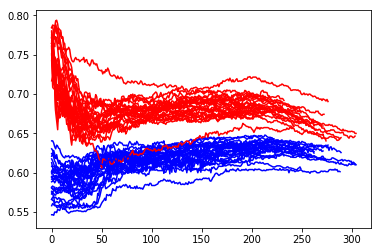

In [55]:
for j in range(30):
    plt.plot(scores_threshold[j][0],'b')
    plt.plot(scores_threshold[j][1], 'r')

Rovnako sme vykreslili priebehy vsetkych modelov. Tuto su uz mensie vykyvy, trendy su jasnejsie: ten lepsi klasifikator sa zhorsuje, ten horsi sa mierne zlepsi

Pozrieme sa este na jednu konretnu dvojicu

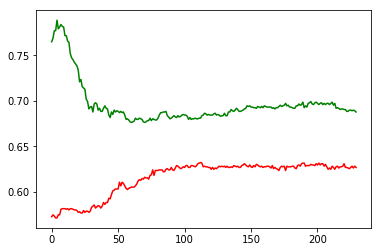

In [56]:
plt.plot(scores_threshold[20][0],'r')
plt.plot(scores_threshold[20][1],'g')

Pozrime sa na skore jednotlivych klasifikatorov a nasledne ich kombinacie:

In [57]:
print("Min: " + str(np.min(model_accuracy1)))
print("Max: " + str(np.max(model_accuracy1)))
print("Avg: " + str(np.mean(model_accuracy1)))
print("Std: " + str(np.std(model_accuracy1)))

Min: 0.5422582826233941
Max: 0.6430020283975659
Avg: 0.6185485688528285
Std: 0.02038371043151163


In [58]:
print("Min: " + str(np.min(model_accuracy2)))
print("Max: " + str(np.max(model_accuracy2)))
print("Avg: " + str(np.mean(model_accuracy2)))
print("Std: " + str(np.std(model_accuracy2)))

Min: 0.6402974983096686
Max: 0.7768762677484787
Avg: 0.6808429118773945
Std: 0.03584968437832753


In [59]:
score_combined = []

for i in range(30):
    score_combined.append(scores_threshold[i][2])

print("Min: " + str(np.min(score_combined)))
print("Max: " + str(np.max(score_combined)))
print("Avg: " + str(np.mean(score_combined)))
print("Std: " + str(np.std(score_combined)))

Min: 0.623394185260311
Max: 0.7038539553752535
Avg: 0.6455262564796034
Std: 0.019091164461717942


Opat, rovnako ako pri co-trainingu s iteraciami, vidime, ze nastalo mierne zlepsenie. V priemere vsak co-training s iteraciami pracoval mierne lepsie.

### Self-training

Self-training je jedna z metod semi-supervised learningu. Kedze je uz implementovany v kniznici, pouzijeme hotove riesenie a len to porovname s co-trainingom.

In [60]:
from frameworks.SelfLearning import *

In [61]:
X_train, X_test, y_train, y_test = ms.train_test_split(X, y, test_size=0.2, random_state=42)

Analogicky ako pri co-trainingu, vypocitame skore pre self-training. Na vstupne mu dame ako aj co-trainingu, 20 olabovanych zaznamov:

In [62]:
scores_self_training = []
for x in range(30):
    
    df_x0 = X_train[y_train == 0].sample(10)
    df_x1 = X_train[y_train == 1].sample(10)
    
    train = pd.concat([df_x0,df_x1])
    y_train_s = y_train.copy()
    y_train_s[y_train.index.difference(train.index)] = -1
    
    
    clf = LogisticRegression(n_jobs=-1)
    ssmodel = SelfLearningModel(clf)
    ssmodel.fit(X_train.as_matrix(), y_train_s.as_matrix())
    
    y_pred = ssmodel.predict(X_test)
    scores_self_training.append(accuracy_score(y_pred,y_test))

Pozrime sa na vysledky, ktore nam self-training dava:

In [63]:
print("Min: " + str(np.min(scores_self_training)))
print("Max: " + str(np.max(scores_self_training)))
print("Avg: " + str(np.mean(scores_self_training)))
print("Std: " + str(np.std(scores_self_training)))

Min: 0.44421906693711966
Max: 0.5963488843813387
Avg: 0.5379310344827586
Std: 0.04052871665959093


Vo vysledkoch vidime velke vykyvy, to zrejme indikuje, ze vysledok velmi zavisi od toho, ake data budu vybrane ako prve, do prvej iteracie.

#### Self-training s vacsim poctom vstupnych oznacenych dat

Skusme teraz dat na vstupe 60 olabovanych dat, co predstavuje priblizne 1% dat:

In [64]:
scores_self_training = []
for x in range(30):
    
    print("iteration:",x)
    df_x0 = X_train[y_train == 0].sample(30)
    df_x1 = X_train[y_train == 1].sample(30)
    
    train = pd.concat([df_x0,df_x1])
    y_train_s = y_train.copy()
    y_train_s[y_train.index.difference(train.index)] = -1
    
    
    clf = LogisticRegression(n_jobs=-1)
    ssmodel = SelfLearningModel(clf)
    ssmodel.fit(X_train.as_matrix(), y_train_s.as_matrix())
    
    y_pred = ssmodel.predict(X_test)
    scores_self_training.append(accuracy_score(y_pred,y_test))

iteration: 0
iteration: 1
iteration: 2
iteration: 3
iteration: 4
iteration: 5
iteration: 6
iteration: 7
iteration: 8
iteration: 9
iteration: 10
iteration: 11
iteration: 12
iteration: 13
iteration: 14
iteration: 15
iteration: 16
iteration: 17
iteration: 18
iteration: 19
iteration: 20
iteration: 21
iteration: 22
iteration: 23
iteration: 24
iteration: 25
iteration: 26
iteration: 27
iteration: 28
iteration: 29


Pozrime sa na skore s vyssim poctom olabovanych dat:

In [65]:
print("Min: " + str(np.min(scores_self_training)))
print("Max: " + str(np.max(scores_self_training)))
print("Avg: " + str(np.mean(scores_self_training)))
print("Std: " + str(np.std(scores_self_training)))

Min: 0.4847870182555781
Max: 0.6105476673427992
Avg: 0.5751183231913455
Std: 0.02580110836571806


### Predikovanie pomocou maleho poctu oznacenych dat bez co-trainingu

Pozrime sa, ci ma vobec co-training zmysel. Skusme poslat rovnako, len 20 olabovanych dat do nasho benchmarkoveho modelu a uvidime, ake dosiahne vysledky.

In [66]:
scores_supervised = []

for x in range(30):
    
    df_x0 = X_train[y_train == 0].sample(10)
    df_x1 = X_train[y_train == 1].sample(10)
    
    train = pd.concat([df_x0,df_x1])
    train['label'] = y_train.loc[train.index]
    
    benchmark_clf = RandomForestClassifier(n_estimators=500, max_depth=20,
                              random_state=10)
    
    benchmark_clf.fit(train[train.columns.difference(['label'])], train['label'])
    y_pred = benchmark_clf.predict(X_test)
    scores_supervised.append(accuracy_score(y_pred,y_test))


Pozrime si statistiku uspesnosti predikcie (metrika accuracy):

In [67]:
print("Min: " + str(np.min(scores_supervised)))
print("Max: " + str(np.max(scores_supervised)))
print("Avg: " + str(np.mean(scores_supervised)))
print("Std: " + str(np.std(scores_supervised)))

Min: 0.4746450304259635
Max: 0.5977011494252874
Avg: 0.49878296146044626
Std: 0.020560173508884495


Ako vidime, accuracy skore je naozaj velmi podobne nahode. **Vzhladom nato, ze co-training dokazal dosiahnut lepsie vysledky, usudzujeme, ze stale ma zmysel ho pouzit.**